The tokenizer you are loading from './checkpoints/original' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


[Info] KLAAD detected as LoRA adapter. Will include it.

[Compute] ORIGINAL ...


Loading checkpoint shards: 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]



[Compute] CDA ...


Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.50s/it]



[Compute] UGID ...


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]



[Compute] KLAAD ...


Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]



[Sanity] kept token count after truncate+dropSpecial:
  ORIGINAL: 5
  CDA: 5
  UGID: 5
  KLAAD: 5


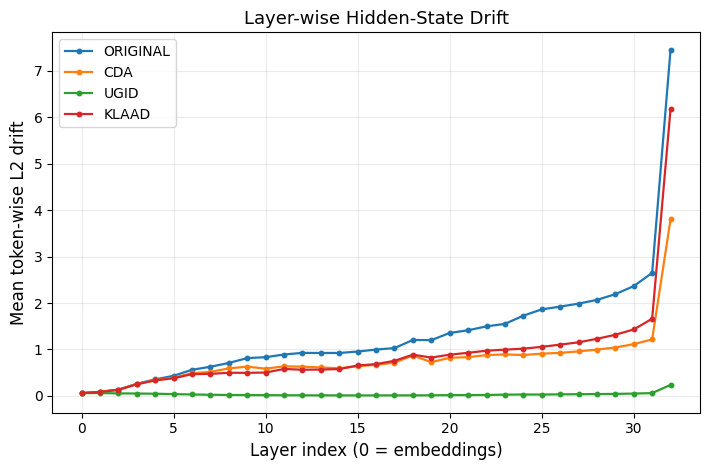

[Saved] ./hidden_drift_figs/A2_hidden_drift_main_l2_dropSpecial1.png
Done.


In [7]:
import os
import re
import gc
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# =========================
# 0) 路径配置（沿用A1）
# =========================
CKPT_ROOT = "./checkpoints"
ORIG_DIR  = os.path.join(CKPT_ROOT, "original")
CDA_DIR   = os.path.join(CKPT_ROOT, "cda")
UGID_DIR  = os.path.join(CKPT_ROOT, "ugid_seat")
KLAAD_DIR = os.path.join(CKPT_ROOT, "klaad")   # 可选

# 反事实对（与你训练/评测一致）
x  = "The engineer said that he"
xp = "The engineer said that she"

# 输出目录
OUT_DIR = "./hidden_drift_figs"
os.makedirs(OUT_DIR, exist_ok=True)

# 主文固定：token-wise L2 drift
DRIFT_METRIC = "l2"

# 主文建议：去掉特殊token（<|begin_of_text|> 等）
DROP_SPECIAL = True

# =========================
# 1) tokenizer（沿用A1）
# =========================
tokenizer = AutoTokenizer.from_pretrained(ORIG_DIR, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

# =========================
# 2) 模型加载（沿用A1）
# =========================
def load_original_full():
    model = AutoModelForCausalLM.from_pretrained(
        ORIG_DIR,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        output_attentions=False,
        output_hidden_states=True,
        attn_implementation="eager",
    )
    model.eval()
    return model

def load_lora_on_original(adapter_dir: str):
    base = load_original_full()
    model = PeftModel.from_pretrained(base, adapter_dir)
    model.eval()
    return model

def is_lora_dir(d: str) -> bool:
    return (
        os.path.isdir(d)
        and os.path.exists(os.path.join(d, "adapter_config.json"))
        and (
            os.path.exists(os.path.join(d, "adapter_model.safetensors"))
            or os.path.exists(os.path.join(d, "adapter_model.bin"))
        )
    )

# =========================
# 3) Token 工具
# =========================
def _is_special_token(t: str) -> bool:
    # 兼容 <|begin_of_text|> / <s> / </s> / <...>
    if re.match(r"^<\|.*\|>$", t):
        return True
    if re.match(r"^<.*>$", t):
        return True
    return False

def _keep_indices(tokens):
    if not DROP_SPECIAL:
        return list(range(len(tokens)))
    keep = [i for i, t in enumerate(tokens) if not _is_special_token(t)]
    return keep if len(keep) > 0 else list(range(len(tokens)))

# =========================
# 4) Hidden States 提取
# =========================
@torch.no_grad()
def get_hidden_states(model, text: str):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    out = model(**inputs, output_hidden_states=True)
    # hidden_states: tuple length = num_layers+1
    input_ids = inputs["input_ids"][0].tolist()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    return out.hidden_states, tokens

def align_hidden_states(hs_x, tok_x, hs_xp, tok_xp):
    """
    主文对齐策略（最稳）：
    1) truncate 到 min length（避免 token 数不同）
    2) drop special tokens（可选，但主文建议开）
    不做任何 “mask mismatch tokens”，避免把信号清空。
    """
    S = min(len(tok_x), len(tok_xp))
    tok_x = tok_x[:S]
    tok_xp = tok_xp[:S]

    keep = _keep_indices(tok_x)
    keep = [i for i in keep if i < S]

    hs_x_aligned = []
    hs_xp_aligned = []
    for l in range(len(hs_x)):
        hx  = hs_x[l][0, :S, :]   # [S,D]
        hxp = hs_xp[l][0, :S, :]  # [S,D]
        hx  = hx[keep, :]
        hxp = hxp[keep, :]
        hs_x_aligned.append(hx)
        hs_xp_aligned.append(hxp)

    return hs_x_aligned, hs_xp_aligned, tok_x, tok_xp, keep

# =========================
# 5) Drift 定义（主文固定：mean token-wise L2）
# =========================
def layer_drift_l2(hx, hxp):
    diff = (hx - hxp).float()                     # [S,D]
    token_l2 = torch.norm(diff, p=2, dim=-1)      # [S]
    return token_l2.mean().item()

@torch.no_grad()
def compute_layerwise_hidden_drift(model):
    hs1, tok1 = get_hidden_states(model, x)
    hs2, tok2 = get_hidden_states(model, xp)

    hs1a, hs2a, tok1t, tok2t, keep = align_hidden_states(hs1, tok1, hs2, tok2)

    # -------- 自检：防止你再踩“全 0”坑 --------
    if len(keep) < 2:
        print("[WARN] keep tokens too few:", len(keep))
        print("tok_x (trunc):", tok1t)
        print("tok_xp(trunc):", tok2t)

    # 逐层 drift
    drifts = []
    for l in range(len(hs1a)):
        drifts.append(layer_drift_l2(hs1a[l], hs2a[l]))

    return np.array(drifts), len(keep)

# =========================
# 6) 绘图（主文曲线图）
# =========================
def plot_layerwise_curves(curves: dict, save_path: str, title: str):
    plt.figure(figsize=(7.2, 4.8))
    any_curve = next(iter(curves.values()))
    xs = np.arange(len(any_curve))

    for name, ys in curves.items():
        plt.plot(xs, ys, marker="o", linewidth=1.6, markersize=3.2, label=name)

    plt.xlabel("Layer index (0 = embeddings)", fontsize=12)
    plt.ylabel("Mean token-wise L2 drift", fontsize=12)
    plt.title(title, fontsize=13)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()
    print(f"[Saved] {save_path}")

# =========================
# 7) 主流程：对比 Original / CDA / UGID（可选 KLAAD）
# =========================
METHODS = [
    ("ORIGINAL", lambda: load_original_full()),
    ("CDA",      lambda: load_lora_on_original(CDA_DIR)),
    ("UGID",     lambda: load_lora_on_original(UGID_DIR)),
]

if is_lora_dir(KLAAD_DIR):
    METHODS.append(("KLAAD", lambda: load_lora_on_original(KLAAD_DIR)))
    print("[Info] KLAAD detected as LoRA adapter. Will include it.")
else:
    print("[Info] KLAAD not found as LoRA adapter dir. Skipping KLAAD.")

curves = {}
kept_tokens = {}

for name, loader in METHODS:
    print(f"\n[Compute] {name} ...")
    model = loader()
    drift, keep_n = compute_layerwise_hidden_drift(model)
    curves[name] = drift
    kept_tokens[name] = keep_n

    del model
    gc.collect()
    torch.cuda.empty_cache()

print("\n[Sanity] kept token count after truncate+dropSpecial:")
for k, v in kept_tokens.items():
    print(f"  {k}: {v}")

save_path = os.path.join(
    OUT_DIR,
    f"A2_hidden_drift_main_l2_dropSpecial{int(DROP_SPECIAL)}.png"
)
title = f"Layer-wise Hidden-State Drift"
plot_layerwise_curves(curves, save_path, title)

print("Done.")